#Pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


!wget -r -l1 -nd -np -A '*.pcap' \
     -P /content/drive/MyDrive/CMP656/dataset/CIC/Benign \
     http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/PCAP/Benign_Final/

!wget -r -l1 -nd -np -A '*.pcap' \
     -P /content/drive/MyDrive/CMP656/dataset/CIC/ArpSpoofing/ \
     http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/PCAP/MITM-ArpSpoofing//

!wget -r -l1 -nd -np -A '*.csv' \
     -P /content/drive/MyDrive/CMP656/dataset/CIC \
     http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/

In [ ]:
#import pandas as pd

#df = pd.read_csv('/content/drive/MyDrive/CMP656/dataset/CIC/Merged01.csv', sep=',')

In [ ]:
!pip install scapy matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.3 MB/s eta 0:00:00


In [ ]:
from scapy.all import rdpcap, Ether, IP, IPv6, TCP, UDP, ARP, ICMP
import pandas as pd
import socket
import struct

def validate_tcp_checksum(pkt) -> bool:
    """
    Validates the TCP checksum of a given packet.
    Returns True if checksum matches, False otherwise.
    """
    if not pkt.haslayer(TCP) or not pkt.haslayer(IP):
        return False

    ip = pkt[IP]
    tcp = pkt[TCP]
    orig_chksum = tcp.chksum

    # Build pseudo-header for IPv4
    src_ip = socket.inet_aton(ip.src)
    dst_ip = socket.inet_aton(ip.dst)
    placeholder = 0
    proto = socket.IPPROTO_TCP
    tcp_length = len(bytes(tcp))

    psh = struct.pack('!4s4sBBH', src_ip, dst_ip, placeholder, proto, tcp_length)
    tcp_bytes = bytes(tcp)

    def checksum(data: bytes) -> int:
        if len(data) % 2:
            data += b'\x00'
        s = sum(struct.unpack('!%dH' % (len(data)//2), data))
        s = (s >> 16) + (s & 0xffff)
        s += s >> 16
        return (~s) & 0xffff

    calc_chksum = checksum(psh + tcp_bytes)
    return calc_chksum == orig_chksum

In [ ]:
from scapy.all import rdpcap, Ether, IP,IPv6, TCP, UDP, ARP, ICMP
import pandas as pd

def extract_selected_features(pcap_path: str) -> pd.DataFrame:
    """
    Reads a pcap file and extracts the selected features per packet,
    including TCP checksum status.
    """
    print("Reading PCAP file.")
    packets = rdpcap(pcap_path)
    print(f"Number of total packages: {len(packets)}")
    records = []
    prev_time = None
    print("Pre-processing is starting.")
    for pkt in packets:
        rec = {
            'frame.len':           len(pkt),
            'ip.proto':            -1,
            'ip.len':              -1,
            'ip.ttl':              -1,
            'ip.flags':            -1,
            'ip.hdr_len':          -1,
            'arp':                 int(pkt.haslayer(ARP)),
            'icmp':                int(pkt.haslayer(ICMP)),
            'tcp.flags.syn':       -1,
            'tcp.flags.ack':       -1,
            'tcp.flags.reset':     -1,
            'tcp.window_size':     -1,
            'tcp.checksum.status': -1,
            'tcp.dstport':         -1,
            'tcp.srcport':         -1,
            'tcp.flags':           -1,
            'tcp.len':             -1,
            'tcp.time_delta':      -1,
            'tcp.urgent_pointer':  -1,
            'udp.srcport':         -1,
            'udp.dstport':         -1,
        }

        # Timestamp for time_delta
        ts = getattr(pkt, 'time', None)
        if prev_time is not None and ts is not None:
            rec['tcp.time_delta'] = ts - prev_time
        prev_time = ts

        # IPv4 layer
        if pkt.haslayer(IP):
            ip = pkt[IP]
            rec.update({
                'ip.proto':   ip.proto,
                'ip.len':     ip.len,
                'ip.ttl':     ip.ttl,
                'ip.flags':   int(ip.flags),
                'ip.hdr_len': ip.ihl * 4,
            })
        # IPv6 layer
        elif pkt.haslayer(IPv6):
            ip6 = pkt[IPv6]
            rec.update({
                'ip.proto':   ip6.nh,
                'ip.len':     ip6.plen,
                'ip.ttl':     ip6.hlim,
                'ip.flags':   0,
                'ip.hdr_len': 40,
            })

        # TCP layer
        if pkt.haslayer(TCP):
            tcp = pkt[TCP]
            flags = tcp.flags
            rec.update({
                'tcp.flags.syn':       int(bool(flags & 0x02)),
                'tcp.flags.ack':       int(bool(flags & 0x10)),
                'tcp.flags.reset':     int(bool(flags & 0x04)),
                'tcp.window_size':     tcp.window,
                'tcp.checksum.status': int(validate_tcp_checksum(pkt)),
                'tcp.dstport':         tcp.dport,
                'tcp.srcport':         tcp.sport,
                'tcp.flags':           int(flags),
                'tcp.len':             len(tcp.payload),
                'tcp.urgent_pointer':  tcp.urgptr,
            })

        # UDP layer
        if pkt.haslayer(UDP):
            udp = pkt[UDP]
            rec.update({
                'udp.srcport': udp.sport,
                'udp.dstport': udp.dport,
            })

        records.append(rec)

    return pd.DataFrame.from_records(records)

# Example usage:
# df_features = extract_selected_features('/content/drive/MyDrive/CMP656/dataset/sample.pcap')
# df_features.head()


In [ ]:

def detect_nan_columns(df: pd.DataFrame) -> list:
    """
    Tüm değerleri NaN olan sütunların listesini döner.
    """
    return df.columns[df.isna().all()].tolist()

In [ ]:
def detect_non_nan_columns(df: pd.DataFrame) -> list:
    """
    Her kayıtta dolu olan (yani hiçbir satırında NaN içermeyen)
    sütunların listesini döner.
    """
    # df.isna().any() → her sütun için “Herhangi bir NaN var mı?” boolean Series
    # ~ ile invert ederek “Hiç NaN yok mu?” sütunlarını seçiyoruz
    return df.columns[~df.isna().any()].tolist()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

#Pre-processing step1
##### 2 DFs ARE STORED IN THE MEMORY
def convert_hex_flags(df: pd.DataFrame) -> pd.DataFrame:
    """
    ip.flags ve tcp.flags onaltılı string ise ondalık integer'a çevirir.
    """
    df = df.copy()
    df['ip.flags']  = df['ip.flags'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
    df['tcp.flags'] = df['tcp.flags'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
    return df

In [ ]:
#Pre-processing step2
def encode_icmp_arp(df: pd.DataFrame) -> pd.DataFrame:
    """
    icmp ve arp sütunlarını kesin 0/1 ikili değerlere dönüştürür.
    """
    df = df.copy()
    df['icmp'] = df['icmp'].apply(lambda x: 1 if x in [1, '1', True] else 0)
    df['arp']  = df['arp'].apply(lambda x: 1 if x in [1, '1', True] else 0)
    return df

In [ ]:
#Pre-processing step3
def mask_protocol_fields(df: pd.DataFrame) -> pd.DataFrame:
    """
    Protocol Type’a göre TCP’ye özgü alanları veya UDP’ye özgü alanları -1 ile maskeler.
    """
    df = df.copy()
    tcp_cols = [
        'tcp.flags.syn','tcp.flags.ack','tcp.flags.reset','tcp.window_size',
        'tcp.checksum.status','tcp.dstport','tcp.srcport','tcp.flags',
        'tcp.len','tcp.time_delta','tcp.urgent_pointer'
    ]
    udp_cols = ['udp.srcport','udp.dstport']
    is_tcp = df['ip.proto'] == 6
    is_udp = df['ip.proto'] == 17
    df.loc[is_tcp, udp_cols] = -1
    df.loc[is_udp, tcp_cols] = -1
    return df

In [ ]:
def oversample_minority(df: pd.DataFrame, label_col: str = 'label') -> pd.DataFrame:
    """
    Eğer Label sütunu varsa, azınlık sınıfı çoğaltılarak sınıf dengesini sağlar.
    """
    if label_col not in df.columns:
        return df
    df = df.copy()
    maj = df[label_col].value_counts().idxmax()
    mino = df[label_col].value_counts().idxmin()
    df_maj = df[df[label_col] == maj]
    df_min = df[df[label_col] == mino]
    df_min_up = resample(df_min, replace=True,
                         n_samples=len(df_maj),
                         random_state=42)
    return pd.concat([df_maj, df_min_up], ignore_index=True)


In [ ]:
def scale_features(df: pd.DataFrame, exclude: list = ['label']) -> pd.DataFrame:
    """
    Tüm sayısal özellikleri [0,1] aralığına ölçekler (Label haric).
    """
    df = df.copy()
    cols = [c for c in df.columns if c not in exclude]
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df

In [ ]:
def add_label(df: pd.DataFrame, label) -> pd.DataFrame:

    df = df.copy()

    # Eğer tek bir değer (scalar) verilmişse, tüm satırlara ata
    if isinstance(label, (int, float)) or (isinstance(label, str) and label.isdigit()):
        df['label'] = int(label)

    return df

In [ ]:
def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    4.2’de tarif edilen tüm adımları sırayla uygular.
    """
    # 0) İstersen NaN-sütunları görebilirsin
    print("Tamamen NaN olan sütunlar:", detect_nan_columns(df))

    # 1) Hex bayrakları dönüştür
    df = convert_hex_flags(df)

    # 2) ICMP/ARP ikili kodlama
    df = encode_icmp_arp(df)

    # 3) Protokole göre maskele
    df = mask_protocol_fields(df)

    # 4) Azınlık sınıfı oversample
    # df = oversample_minority(df)

    # 5) Min–Max ölçekleme
    df = scale_features(df)

    return df


In [ ]:
def process(pcap_path, label):
  df = extract_selected_features(pcap_path)
  df = preprocess_df(df)
  df = add_label(df,label)
  return df

In [ ]:
def df_to_numpy(df: pd.DataFrame, label_col: str = 'label'):
    """
    DataFrame’i (df) iki NumPy dizisine dönüştürür:
      - X: Özellik matrisi (num_samples × num_features)
      - y: Etiket vektörü (num_samples,)

    label_col ile belirtilen sütun etiket olarak ayrılır.
    """
    # 1) Özellik sütunlarını seç
    feature_cols = [c for c in df.columns if c != label_col]
    X = df[feature_cols].to_numpy(dtype=np.float32)

    # 2) Etiket sütununu al
    y = df[label_col].to_numpy(dtype=np.int64)

    return X, y

#Load IoT Network Intrusion Dataset

In [1]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-1-dec.pcap \
#  -Y 'eth.addr == f0:18:98:5e:ff:9f && (((ip.src == 192.168.0.16 && ip.dst == 192.168.0.13) || (ip.src == 192.168.0.13 && ip.dst == 192.168.0.16)) && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == bc:1c:81:4b:ae:ba || arp.dst.hw_mac == 48:4b:aa:2c:d8:f9))' \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-1-attack-dec.pcap

In [2]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-1-dec.pcap \
#  -Y '!(eth.addr == f0:18:98:5e:ff:9f && (((ip.src == 192.168.0.16 && ip.dst == 192.168.0.13) || (ip.src == 192.168.0.13 && ip.dst == 192.168.0.16)) && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == bc:1c:81:4b:ae:ba || arp.dst.hw_mac == 48:4b:aa:2c:d8:f9)))' \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-1-not-attack-dec.pcap

In [3]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-2-dec.pcap \
#  -Y 'eth.addr == f0:18:98:5e:ff:9f && (((ip.src == 192.168.0.16 && ip.dst == 192.168.0.13) || (ip.src == 192.168.0.13 && ip.dst == 192.168.0.16)) && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == bc:1c:81:4b:ae:ba || arp.dst.hw_mac == 48:4b:aa:2c:d8:f9))' \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-2-attack-dec.pcap

In [4]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-2-dec.pcap \
#  -Y '!(eth.addr == f0:18:98:5e:ff:9f && (((ip.src == 192.168.0.16 && ip.dst == 192.168.0.13) || (ip.src == 192.168.0.13 && ip.dst == 192.168.0.16)) && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == bc:1c:81:4b:ae:ba || arp.dst.hw_mac == 48:4b:aa:2c:d8:f9)))' \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-2-not-attack-dec.pcap

In [5]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-3-dec.pcap \
#  -Y 'eth.addr == f0:18:98:5e:ff:9f && (((ip.src == 192.168.0.16 && ip.dst == 192.168.0.13) || (ip.src == 192.168.0.13 && ip.dst == 192.168.0.16)) && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == bc:1c:81:4b:ae:ba || arp.dst.hw_mac == 48:4b:aa:2c:d8:f9))' \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-3-attack-dec.pcap

In [6]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-3-dec.pcap \
#  -Y '!(eth.addr == f0:18:98:5e:ff:9f && (((ip.src == 192.168.0.16 && ip.dst == 192.168.0.13) || (ip.src == 192.168.0.13 && ip.dst == 192.168.0.16)) && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == bc:1c:81:4b:ae:ba || arp.dst.hw_mac == 48:4b:aa:2c:d8:f9)))' \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-3-not-attack-dec.pcap

In [7]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-4-dec.pcap \
#    -Y "eth.addr == f0:18:98:5e:ff:9f && ((ip.addr == 192.168.0.24 && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == 04:32:f4:45:17:b3 || arp.dst.hw_mac == 88:36:6c:d7:1c:56)))" \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-4-attack-dec.pcap

In [8]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-4-dec.pcap \
#    -Y "!(eth.addr == f0:18:98:5e:ff:9f && ((ip.addr == 192.168.0.24 && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == 04:32:f4:45:17:b3 || arp.dst.hw_mac == 88:36:6c:d7:1c:56))))" \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-4-not-attack-dec.pcap

In [9]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-5-dec.pcap \
#    -Y "eth.addr == f0:18:98:5e:ff:9f && ((ip.addr == 192.168.0.24 && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == 04:32:f4:45:17:b3 || arp.dst.hw_mac == 88:36:6c:d7:1c:56)))" \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-5-attack-dec.pcap

In [10]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-5-dec.pcap \
#    -Y "!(eth.addr == f0:18:98:5e:ff:9f && ((ip.addr == 192.168.0.24 && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == 04:32:f4:45:17:b3 || arp.dst.hw_mac == 88:36:6c:d7:1c:56))))" \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-5-not-attack-dec.pcap

In [11]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-6-dec.pcap \
#    -Y "eth.addr == f0:18:98:5e:ff:9f && ((ip.addr == 192.168.0.24 && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == 04:32:f4:45:17:b3 || arp.dst.hw_mac == 88:36:6c:d7:1c:56)))" \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-6-attack-dec.pcap

In [12]:
#!tshark -r /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-6-dec.pcap \
#    -Y "!(eth.addr == f0:18:98:5e:ff:9f && ((ip.addr == 192.168.0.24 && tcp && !icmp) || (arp.src.hw_mac == f0:18:98:5e:ff:9f && (arp.dst.hw_mac == 04:32:f4:45:17:b3 || arp.dst.hw_mac == 88:36:6c:d7:1c:56))))" \
#  -w /content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-6-not-attack-dec.pcap

In [13]:
import os
from scapy.all import rdpcap
import pandas as pd
import matplotlib.pyplot as plt

pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-1-attack-dec.pcap'
df = process(pcap_path, 1)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-2-attack-dec.pcap'
df_to_add = process(pcap_path, 1)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-3-attack-dec.pcap'
df_to_add = process(pcap_path, 1)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-4-attack-dec.pcap'
df_to_add = process(pcap_path, 1)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-5-attack-dec.pcap'
df_to_add = process(pcap_path, 1)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-6-attack-dec.pcap'
df_to_add = process(pcap_path, 1)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)

pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-1-not-attack-dec.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-2-not-attack-dec.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-3-not-attack-dec.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-4-not-attack-dec.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-5-not-attack-dec.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/mitm-arpspoofing-6-not-attack-dec.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)

pcap_path = '/content/drive/MyDrive/CMP656/dataset/IoT_Network_Intrusion_Dataset/benign-dec.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)


ModuleNotFoundError: No module named 'scapy'

In [ ]:
df.columns

# Train ARP-PROBE

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = df_to_numpy(df)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, shuffle=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.from_numpy(X_train).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
X_test_t  = torch.from_numpy(X_test).to(device)
y_test_t  = torch.from_numpy(y_test).to(device)

batch_size = 64
train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [ ]:
test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1) MLP modelini tanımla
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 2) Model, loss, optimizer ayarları
input_dim   = X_train.shape[1]              # özellik sayısı
hidden_dims = [42, 16,8,8]                     # istediğin mimari
output_dim  = len(torch.unique(y_train_t))  # sınıf sayısı

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, hidden_dims, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
test_loader = lastTestLoader

In [ ]:

num_epochs = 15
for epoch in range(1, num_epochs+1):
    # --- TRAINING ---
    model.train()
    total_loss = 0.0
    train_correct = 0
    train_total   = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * yb.size(0)          # loss'u batch büyüklüğü ile ağırlıkla
        preds      = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()     # doğru sayısını topla
        train_total   += yb.size(0)                     # toplam örnek sayısı

    avg_loss    = total_loss / train_total
    train_acc   = train_correct / train_total

    # --- VALIDATION ---
    model.eval()
    val_correct = 0
    val_total   = 0

    with torch.no_grad():
        for xb, yb in test_loader:                     # test_loader = validation set
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds  = logits.argmax(dim=1)

            val_correct += (preds == yb).sum().item()
            val_total   += yb.size(0)

    val_acc = val_correct / val_total

    # --- LOGGING ---
    print(f"Epoch {epoch:2d}/{num_epochs} – "
          f"Loss: {avg_loss:.4f} – "
          f"Train Acc: {train_acc:.4f} – "
          f"Val Acc: {val_acc:.4f}")

Epoch  1/15 – Loss: 0.0194 – Train Acc: 0.9937 – Val Acc: 0.9988
Epoch  2/15 – Loss: 0.0019 – Train Acc: 0.9989 – Val Acc: 0.9988
Epoch  3/15 – Loss: 0.0013 – Train Acc: 0.9995 – Val Acc: 0.9999
Epoch  4/15 – Loss: 0.0009 – Train Acc: 0.9997 – Val Acc: 0.9999
Epoch  5/15 – Loss: 0.0008 – Train Acc: 0.9997 – Val Acc: 0.9998
Epoch  6/15 – Loss: 0.0007 – Train Acc: 0.9997 – Val Acc: 0.9998
Epoch  7/15 – Loss: 0.0007 – Train Acc: 0.9997 – Val Acc: 0.9999
Epoch  8/15 – Loss: 0.0007 – Train Acc: 0.9997 – Val Acc: 0.9999
Epoch  9/15 – Loss: 0.0006 – Train Acc: 0.9997 – Val Acc: 0.9999
Epoch 10/15 – Loss: 0.0006 – Train Acc: 0.9997 – Val Acc: 0.9999
Epoch 11/15 – Loss: 0.0006 – Train Acc: 0.9997 – Val Acc: 0.9998
Epoch 12/15 – Loss: 0.0007 – Train Acc: 0.9997 – Val Acc: 0.9998
Epoch 13/15 – Loss: 0.0006 – Train Acc: 0.9997 – Val Acc: 0.9999
Epoch 14/15 – Loss: 0.0007 – Train Acc: 0.9997 – Val Acc: 0.9999
Epoch 15/15 – Loss: 0.0005 – Train Acc: 0.9998 – Val Acc: 0.9999


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/CMP656/model/mlp_classifier2.pth")

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/CMP656/model/mlp_classifier1.pth", map_location=device))

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load("mlp_classifier.pth", map_location=device))
#import torch
#import torch.nn as nn
#import torch.optim as optim

# 1) MLP modelini tanımla
#class MLP(nn.Module):
 #   def __init__(self, input_dim, hidden_dims, output_dim):
  #      super().__init__()
   #     layers = []
    #    prev_dim = input_dim
     #   for h in hidden_dims:
#            layers.append(nn.Linear(prev_dim, h))
 #           layers.append(nn.ReLU())
  #          prev_dim = h
   #     layers.append(nn.Linear(prev_dim, output_dim))
    #    self.net = nn.Sequential(*layers)

   # def forward(self, x):
    #    return self.net(x)

# 2) Model, loss, optimizer ayarları
#input_dim   = X_train.shape[1]              # özellik sayısı
#hidden_dims = [42, 16,8,8]                     # istediğin mimari
#output_dim  = len(torch.unique(y_train_t))  # sınıf sayısı

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = MLP(input_dim, hidden_dims, output_dim).to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Test ARP-PROBE on CIC IoT 2023 Dataset

In [ ]:
import os
from scapy.all import rdpcap
import pandas as pd
import matplotlib.pyplot as plt

pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/MITM-ArpSpoofing/MITM-ArpSpoofing.pcap'
df = process(pcap_path, 1)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/MITM-ArpSpoofing/MITM-ArpSpoofing1.pcap'
df_to_add = process(pcap_path, 1)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/Benign_Final/BenignTraffic.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/Benign_Final/BenignTraffic1.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/Benign_Final/BenignTraffic2.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/Benign_Final/BenignTraffic3.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)


Reading PCAP file.
Number of total packages: 2491622
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 600143
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 3664164
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 2988642
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 3138002
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 1311897
Pre-processing is starting.
Tamamen NaN olan sütunlar: []


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_test, y_test = df_to_numpy(df)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_t  = torch.from_numpy(X_test).to(device)
y_test_t  = torch.from_numpy(y_test).to(device)

batch_size = 64

test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [ ]:

lastTestLoader = DataLoader(
    dataset=test_loader.dataset,
    batch_size=test_loader.batch_size,
    shuffle=False,               # test loader’da genelde shuffle=False olur
    sampler=test_loader.sampler,        # eğer orijinalde custom bir sampler kullandıysanız
    num_workers=test_loader.num_workers,
    pin_memory=test_loader.pin_memory,
    drop_last=test_loader.drop_last,
    collate_fn=test_loader.collate_fn
)

In [ ]:
# 4) Test (Değerlendirme)
model.eval()
correct = 0
total   = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds  = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)

accuracy = correct / total
print(f"Test Doğruluk: {accuracy:.4f}")

Test Doğruluk: 0.9998


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_test, y_test = df_to_numpy(df)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_t  = torch.from_numpy(X_test).to(device)
y_test_t  = torch.from_numpy(y_test).to(device)

batch_size = 64

test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [ ]:
# 4) Test (Değerlendirme)
model.eval()
test_correct = 0
test_total   = 0

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds  = logits.argmax(dim=1)
        test_correct += (preds == yb).sum().item()
        test_total   += yb.size(0)

test_acc = test_correct / test_total
print(f"Test Doğruluk: {test_acc:.4f}")

Test Doğruluk: 0.5114


#CIC_IOT_Dataset2023 Flow-Level (Original merged csv 40 features)

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

# --- ek kütüphaneler ---
import torch
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder, StandardScaler

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dosya listesi ve bölme ---
DATASET_DIRECTORY = '/content/drive/MyDrive/CMP656/dataset/CIC/'

# 1) Dosya listesini al
df_sets = [f for f in os.listdir(DATASET_DIRECTORY) if f.endswith('.csv')]

# 2) Karıştır (shuffle) — istersen sabit bir seed ile
random.seed(42)
random.shuffle(df_sets)

# 3) Bölme indisi hesapla
n = len(df_sets)
train_end = int(n * 0.8)  # %80 eğitim
val_end   = train_end + int(n * 0.1)  # sonraki %10 validasyon

# 4) Ayır
training_sets   = df_sets[:train_end]
validation_sets = df_sets[train_end:val_end]

print(f"Train: {len(training_sets)} files\n"
      f"Val:   {len(validation_sets)} files\n")

Train: 50 files
Val:   6 files



In [ ]:
X_columns = [
     'Header_Length', 'Protocol Type', 'Time_To_Live',
       'Rate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'rst_count',
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
        'Variance'
]

y_column = 'Label'

In [ ]:
all_labels = ['DDOS-PSHACK_FLOOD', 'MIRAI-GREIP_FLOOD', 'DOS-UDP_FLOOD',
       'DNS_SPOOFING', 'DDOS-ICMP_FLOOD', 'DDOS-TCP_FLOOD',
       'DDOS-SYN_FLOOD', 'DDOS-UDP_FLOOD', 'MITM-ARPSPOOFING',
       'DDOS-SYNONYMOUSIP_FLOOD', 'DOS-TCP_FLOOD', 'VULNERABILITYSCAN',
       'DOS-SYN_FLOOD', 'DDOS-RSTFINFLOOD', 'BENIGN', 'DDOS-SLOWLORIS',
       'DDOS-ICMP_FRAGMENTATION', 'MIRAI-GREETH_FLOOD',
       'RECON-HOSTDISCOVERY', 'MIRAI-UDPPLAIN', 'RECON-PORTSCAN',
       'DDOS-ACK_FRAGMENTATION', 'DDOS-UDP_FRAGMENTATION', 'RECON-OSSCAN',
       'BACKDOOR_MALWARE', 'DOS-HTTP_FLOOD', 'XSS', 'DDOS-HTTP_FLOOD',
       'BROWSERHIJACKING', 'SQLINJECTION', 'DICTIONARYBRUTEFORCE',
       'COMMANDINJECTION', 'RECON-PINGSWEEP', 'UPLOADING_ATTACK']


In [ ]:
scaler = StandardScaler()
for fn in tqdm(training_sets, desc="Fitting scaler"):
    path = os.path.join(DATASET_DIRECTORY, fn)
    df   = pd.read_csv(path)
    Xc   = (
        df[X_columns]
          .apply(pd.to_numeric, errors='coerce')
          .replace([np.inf, -np.inf], np.nan)
          .fillna(-1)
    )
    scaler.partial_fit(Xc.values)


Fitting scaler: 100%|██████████| 50/50 [04:19<00:00,  5.18s/it]


In [ ]:
scaler

StandardScaler()

In [ ]:
le = LabelEncoder()
# LabelEncoder.partial_fit yok, bu yüzden tüm eğitim label’larını bir listede topluyoruz
all_labels = [ 'DDOS-PSHACK_FLOOD', 'MIRAI-GREIP_FLOOD', 'DOS-UDP_FLOOD',
       'DNS_SPOOFING', 'DDOS-ICMP_FLOOD', 'DDOS-TCP_FLOOD',
       'DDOS-SYN_FLOOD', 'DDOS-UDP_FLOOD', 'MITM-ARPSPOOFING',
       'DDOS-SYNONYMOUSIP_FLOOD', 'DOS-TCP_FLOOD', 'VULNERABILITYSCAN',
       'DOS-SYN_FLOOD', 'DDOS-RSTFINFLOOD', 'BENIGN', 'DDOS-SLOWLORIS',
       'DDOS-ICMP_FRAGMENTATION', 'MIRAI-GREETH_FLOOD',
       'RECON-HOSTDISCOVERY', 'MIRAI-UDPPLAIN', 'RECON-PORTSCAN',
       'DDOS-ACK_FRAGMENTATION', 'DDOS-UDP_FRAGMENTATION', 'RECON-OSSCAN',
       'BACKDOOR_MALWARE', 'DOS-HTTP_FLOOD', 'XSS', 'DDOS-HTTP_FLOOD',
       'BROWSERHIJACKING', 'SQLINJECTION', 'DICTIONARYBRUTEFORCE',
       'COMMANDINJECTION', 'RECON-PINGSWEEP', 'UPLOADING_ATTACK']
le.fit(all_labels)
num_classes = len(le.classes_)

In [ ]:
import torch
from torch import nn, optim

class DeepNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, p_dropout=0.3):
        """
        input_dim   : Öznitelik sayısı
        hidden_dims : Gizli katman boyutları listesi, örn. [256, 128, 64]
        num_classes : Sınıf sayısı
        p_dropout   : Dropout oranı
        """
        super().__init__()
        layers = []
        prev_dim = input_dim

        for h in hidden_dims:
            layers += [
                nn.Linear(prev_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(inplace=True),
                nn.Dropout(p_dropout)
            ]
            prev_dim = h

        # Son sınıflandırma katmanı
        layers += [
            nn.Linear(prev_dim, num_classes),
            nn.LogSoftmax(dim=1)
        ]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --- Model başlatma ve optimizasyon ---
input_dim   = len(X_columns)
hidden_dims = [128, 64, 32]               # 3 katmanlı örnek
num_classes = num_classes                  # daha önce hesaplanmış
model       = DeepNet(input_dim, hidden_dims, num_classes, p_dropout=0.3).to(device)

criterion = nn.NLLLoss()                   # LogSoftmax kullandığımız için NLLLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# (İsteğe bağlı) learning-rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
num_epochs = 10
batch_size = 2048

for epoch in range(1, num_epochs+1):
    # --- Training ---
    model.train()
    running_loss = 0.0
    train_correct = 0
    seen = 0

    for fn in tqdm(training_sets, desc=f"Epoch {epoch} [Train]"):
        df = pd.read_csv(os.path.join(DATASET_DIRECTORY, fn))
        df = df.dropna(subset=[y_column])
        Xc = (
            df[X_columns]
              .apply(pd.to_numeric, errors='coerce')
              .replace([np.inf, -np.inf], np.nan)
              .fillna(-1)
        )
        Xs = scaler.transform(Xc.values)
        ys = le.transform(df[y_column].astype(str).values)

        X_t = torch.from_numpy(Xs).float().to(device)
        y_t = torch.from_numpy(ys).long().to(device)

        for i in range(0, len(X_t), batch_size):
            xb = X_t[i:i+batch_size]
            yb = y_t[i:i+batch_size]

            optimizer.zero_grad()
            logits = model(xb)
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            seen         += xb.size(0)
            preds = logits.argmax(dim=1)
            train_correct += (preds == yb).sum().item()

    train_loss = running_loss / seen
    train_acc  = train_correct / seen

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_seen = 0
    val_correct = 0

    with torch.no_grad():
        for fn in tqdm(validation_sets, desc=f"Epoch {epoch} [Valid]"):
            df = pd.read_csv(os.path.join(DATASET_DIRECTORY, fn))
            df = df.dropna(subset=[y_column])
            Xc = (
                df[X_columns]
                  .apply(pd.to_numeric, errors='coerce')
                  .replace([np.inf, -np.inf], np.nan)
                  .fillna(-1)
            )
            Xs = scaler.transform(Xc.values)
            ys = le.transform(df[y_column].astype(str).values)

            X_t = torch.from_numpy(Xs).float().to(device)
            y_t = torch.from_numpy(ys).long().to(device)

            for i in range(0, len(X_t), batch_size):
                xb = X_t[i:i+batch_size]
                yb = y_t[i:i+batch_size]

                logits = model(xb)
                loss   = criterion(logits, yb)

                val_loss   += loss.item() * xb.size(0)
                val_seen   += xb.size(0)
                val_correct += (logits.argmax(dim=1) == yb).sum().item()

    val_loss = val_loss / val_seen
    val_acc  = val_correct / val_seen

    print(
        f"Epoch {epoch} — "
        f"Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.4f}  |  "
        f"Val Loss:   {val_loss:.4f}  |  Val Acc:   {val_acc:.4f}"
    )

Epoch 1 [Valid]: 100%|██████████| 6/6 [00:34<00:00,  5.72s/it]


Epoch 1 — Train Loss: 0.5152  |  Train Acc: 0.7419  |  Val Loss:   0.4675  |  Val Acc:   0.7564


Epoch 2 [Valid]: 100%|██████████| 6/6 [00:23<00:00,  3.95s/it]


Epoch 2 — Train Loss: 0.4748  |  Train Acc: 0.7590  |  Val Loss:   0.4554  |  Val Acc:   0.7690


Epoch 3 [Valid]: 100%|██████████| 6/6 [00:23<00:00,  3.95s/it]


Epoch 3 — Train Loss: 0.4736  |  Train Acc: 0.7597  |  Val Loss:   0.4477  |  Val Acc:   0.7706


Epoch 4 [Valid]: 100%|██████████| 6/6 [00:23<00:00,  3.98s/it]


Epoch 4 — Train Loss: 0.4712  |  Train Acc: 0.7611  |  Val Loss:   0.4442  |  Val Acc:   0.7709


Epoch 5 [Valid]: 100%|██████████| 6/6 [00:23<00:00,  3.99s/it]


Epoch 5 — Train Loss: 0.4689  |  Train Acc: 0.7622  |  Val Loss:   0.4450  |  Val Acc:   0.7714


Epoch 6 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.00s/it]


Epoch 6 — Train Loss: 0.4676  |  Train Acc: 0.7626  |  Val Loss:   0.4446  |  Val Acc:   0.7709


Epoch 7 [Valid]: 100%|██████████| 6/6 [00:23<00:00,  3.98s/it]


Epoch 7 — Train Loss: 0.4665  |  Train Acc: 0.7632  |  Val Loss:   0.4435  |  Val Acc:   0.7709


Epoch 8 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.02s/it]


Epoch 8 — Train Loss: 0.4639  |  Train Acc: 0.7640  |  Val Loss:   0.4407  |  Val Acc:   0.7719


Epoch 9 [Valid]: 100%|██████████| 6/6 [00:24<00:00,  4.02s/it]


Epoch 9 — Train Loss: 0.4636  |  Train Acc: 0.7640  |  Val Loss:   0.4400  |  Val Acc:   0.7726


Epoch 10 [Valid]: 100%|██████████| 6/6 [00:23<00:00,  3.98s/it]

Epoch 10 — Train Loss: 0.4646  |  Train Acc: 0.7633  |  Val Loss:   0.4430  |  Val Acc:   0.7729


In [ ]:
model.eval()
correct = 0
total   = 0

with torch.no_grad():
    for fn in tqdm(test_sets, desc="Evaluating"):
        df = pd.read_csv(os.path.join(DATASET_DIRECTORY, fn))
        Xc = (
            df[X_columns]
              .apply(pd.to_numeric, errors='coerce')
              .replace([np.inf, -np.inf], np.nan)
              .fillna(-1)
        )
        Xs = scaler.transform(Xc.values)
        ys = le.transform(df[y_column].astype(str).values)

        X_t = torch.from_numpy(Xs).float().to(device)
        y_t = torch.from_numpy(ys).long().to(device)

        preds = model(X_t).argmax(dim=1)
        correct += (preds == y_t).sum().item()
        total   += y_t.size(0)

print(f"Test Accuracy: {correct/total:.4f}")

NameError: name 'test_sets' is not defined

#CIC_IOT_Dataset2023 Flow-Level (NFStream 80 features)

### Use this part to download CIC IoT 2023 .pcap files.

```
import os
import requests
from bs4 import BeautifulSoup

BASE_URL = "http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/PCAP"
DEST     = "/content/drive/MyDrive/CMP656/dataset/CIC"

os.makedirs(DEST, exist_ok=True)
resp = requests.get(BASE_URL + "/")
soup = BeautifulSoup(resp.text, "html.parser")

# 1) Ana dizindeki alt klasörleri bul
for a in soup.find_all("a"):
    href = a.get("href", "")
    # klasör ise (sonunda / var)
    if not href.endswith("/"):
        continue
    subdir = href.rstrip("/")
    sub_url = f"{BASE_URL}/{subdir}/"
    os.makedirs(os.path.join(DEST, subdir), exist_ok=True)
    print(f"Entering {subdir}")

    # 2) O klasördeki .pcap dosyalarını listele, ilk 4’ünü al
    resp2 = requests.get(sub_url)
    soup2 = BeautifulSoup(resp2.text, "html.parser")
    pcaps = [a2.get("href") for a2 in soup2.find_all("a") if a2.get("href","").endswith(".pcap")]
    for pcap in pcaps[:4]:
        url  = sub_url + pcap
        dst  = os.path.join(DEST, subdir, pcap)
        print(f"  Downloading {pcap}...")
        r = requests.get(url, stream=True)
        with open(dst, "wb") as f:
            for chunk in r.iter_content(1024):
                f.write(chunk)
```



In [ ]:
!pip install nfstream

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 16.1 MB/s eta 0:00:00


### Use this part to generate .csv flow files from .pcap files

```
import os
from nfstream import NFStreamer
from tqdm import tqdm
import pandas as pd

# PCAP kök dizini
PCAP_DIRECTORY = '/content/drive/MyDrive/CMP656/dataset/CIC'

# Tüm alt dizinlerdeki pcap dosyalarını gez
for root, dirs, files in os.walk(PCAP_DIRECTORY):
    for fname in files:
        if not fname.endswith('.pcap'):
            continue

        pcap_path = os.path.join(root, fname)
        # Çıktı CSV dosya yolu: aynı klasörde, .pcap -> .csv
        csv_path = os.path.splitext(pcap_path)[0] + '.csv'

        # Eğer çıktı zaten varsa atla
        if os.path.exists(csv_path):
            print(f"Skipping {fname}, already exists.")
            continue

        print(f"Processing {fname} ...")
        # NFStream ile flow’ları çıkar
        streamer = NFStreamer(
          source=pcap_path,
          decode_tunnels=True,          # Tünellenmiş (VXLAN, GRE vb.) trafiği analiz et
          statistical_analysis=True    # İstatistiksel analizleri (IAT, packet sizes) etkinleştir
)

        df_flow = streamer.to_pandas()

        # Label: bulunduğu klasörün adı, büyük harf
        label = os.path.basename(root).upper()
        df_flow['label'] = label

        # CSV olarak kaydet
        df_flow.to_csv(csv_path, index=False)
        # Belleği boşalt
        del df_flow
```



In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import gc # Garbage Collector modülünü içe aktar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

# --- YENİ: Bellek Kullanımını Azaltma Fonksiyonu ---
def reduce_mem_usage(df, verbose=True):
    """DataFrame'deki kolonların veri tiplerini optimize ederek bellek kullanımını azaltır."""
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df
# ----------------------------------------------------


# CSV dosyalarının bulunduğu kök dizin
CSV_DIRECTORY = '/content/drive/MyDrive/CMP656/dataset/CIC'
print(f"Searching for CSV files in subdirectories of: {CSV_DIRECTORY}")

csv_files = glob.glob(os.path.join(CSV_DIRECTORY, '*', '*.csv'))

if not csv_files:
    print("No CSV files found...")
else:
    print(f"Found {len(csv_files)} CSV files in subdirectories.")

    df_list = []
    for f in tqdm(csv_files, desc="Loading CSV files"):
        try:
            df_list.append(pd.read_csv(f))
        except Exception as e:
            print(f"Could not read {f}: {e}")

    df = pd.concat(df_list, ignore_index=True)
    print("All CSV files have been concatenated into a single DataFrame.")

    # --- BELLEK TEMİZLİĞİ 1 ---
    # df_list artık gerekli değil, belleği boşaltalım.
    del df_list
    gc.collect()
    print("Cleaned up df_list from memory.")
    # --------------------------

    # --- YENİ: Veri tiplerini optimize et ---
    df = reduce_mem_usage(df)
    # -------------------------------------

    print("-" * 50)
    print("Initial DataFrame Info:")
    df.info(verbose=False)
    print("\nLabel Distribution:")
    print(df['label'].value_counts())
    print("-" * 50)

    # Adım 2: Veri Temizliği ve Özellik Mühendisliği
    columns_to_drop = [
        'id', 'expiration_id', 'src_ip', 'src_mac', 'src_port', 'dst_ip', 'dst_mac', 'dst_port',
        'src_oui', 'dst_oui', 'ip_version', 'vlan_id', 'tunnel_id', 'bidirectional_first_seen_ms',
        'bidirectional_last_seen_ms', 'src2dst_first_seen_ms', 'src2dst_last_seen_ms',
        'dst2src_first_seen_ms', 'dst2src_last_seen_ms', 'application_name',
        'application_is_guessed', 'requested_server_name', 'client_fingerprint',
        'server_fingerprint', 'user_agent', 'content_type'
    ]
    existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    df.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"Dropped {len(existing_cols_to_drop)} unnecessary columns.")

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if 'label' in categorical_cols:
        categorical_cols.remove('label')


    if categorical_cols:
        print(f"\nApplying One-Hot Encoding to: {categorical_cols}")
        df = pd.get_dummies(df, columns=categorical_cols, dummy_na=True, prefix=categorical_cols)

    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

    # ... Diğer adımlar ...
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    X = df.drop(columns=['label'])
    y = df['label']

    # --- ÇÖZÜM: Kolon isimlerini X'i silmeden önce bir listeye kaydet ---
    feature_names = X.columns.tolist()
    print("Feature names have been saved to a list.")

    # --- BELLEK TEMİZLİĞİ 2 ---
    # df artık gerekli değil, X ve y oluşturuldu.
    original_columns = list(df.columns)
    del df
    gc.collect()
    print("Cleaned up main DataFrame from memory.")
    # --------------------------

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- BELLEK TEMİZLİĞİ 3 ---
    # X ve y artık gerekli değil, train/test setleri oluşturuldu.
    del X, y
    gc.collect()
    print("Cleaned up X and y from memory.")
    # --------------------------

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- BELLEK TEMİZLİĞİ 4 ---
    # Ölçeklenmemiş train/test setleri artık gerekli değil.
    del X_train, X_test
    gc.collect()
    print("Cleaned up unscaled train/test sets from memory.")
    # --------------------------

    print("-" * 50)
    print("Pre-processing complete! You can now use the following variables for model training:")
    print(f"X_train_scaled: (shape {X_train_scaled.shape})")
    print(f"y_train: (shape {y_train.shape})")
    print(f"X_test_scaled: (shape {X_test_scaled.shape})")
    print(f"y_test: (shape {y_test.shape})")

Searching for CSV files in subdirectories of: /content/drive/MyDrive/CMP656/dataset/CIC
Found 87 CSV files in subdirectories.


Loading CSV files:   6%|▌         | 5/87 [00:10<02:42,  1.98s/it]<ipython-input-18-2668725265>:54: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:   8%|▊         | 7/87 [00:11<01:28,  1.11s/it]<ipython-input-18-2668725265>:54: DtypeWarning: Columns (82,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:   9%|▉         | 8/87 [00:11<01:20,  1.02s/it]<ipython-input-18-2668725265>:54: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:  10%|█         | 9/87 [00:12<01:02,  1.24it/s]<ipython-input-18-2668725265>:54: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:  11%|█▏        | 10/87 [00:19<0

All CSV files have been concatenated into a single DataFrame.
Cleaned up df_list from memory.
Memory usage decreased to 11396.47 Mb (50.3% reduction)
--------------------------------------------------
Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34537749 entries, 0 to 34537748
Columns: 87 entries, id to label
dtypes: float32(12), int16(8), int32(25), int64(6), int8(22), object(14)
memory usage: 11.1+ GB

Label Distribution:
label
DDOS-SYN_FLOOD             7057085
DDOS-TCP_FLOOD             6485994
DDOS-RSTFINFLOOD           5940621
DDOS-PSHACK_FLOOD          5564499
DDOS-ACK_FRAGMENTATION     1925646
DOS-SYN_FLOOD              1538449
DOS-TCP_FLOOD              1100277
BENIGN_FINAL                929777
DDOS-SYNONYMOUSIP_FLOOD     811277
DOS-UDP_FLOOD               763679
RECON-HOSTDISCOVERY         415348
DDOS-HTTP_FLOOD             380587
VULNERABILITYSCAN           370456
DOS-HTTP_FLOOD              216354
RECON-PORTSCAN              188592
RECON-OSSCAN

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# --- 1. Cihaz Kurulumu ve Veri Hazırlığı ---

# Cihazı belirle (GPU varsa kullan, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---")

# NumPy dizilerini PyTorch Tensor'larına dönüştür
# Özellikler float, etiketler ise CrossEntropyLoss için long olmalı
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long) # y_train bir Pandas Serisi olduğu için .values kullandık
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# DataLoader'ları oluştur (Veriyi toplu halde ve karıştırarak modele sunmak için)
BATCH_SIZE = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Test/Validation verisi için de DataLoader oluştur
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. Deep Learning Model Tanımı ---

class DeepNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, p_dropout=0.4):
        """
        input_dim   : Giriş özellik sayısı
        hidden_dims : Gizli katman boyutları listesi, örn. [128, 64, 32]
        num_classes : Sınıf sayısı
        p_dropout   : Dropout oranı
        """
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, h),
                nn.BatchNorm1d(h),      # Katmanlar arası normalizasyon
                nn.ReLU(),  # Aktivasyon fonksiyonu
                nn.Dropout(p_dropout)   # Overfitting'i önlemek için
            ])
            prev_dim = h

        # Son katman (logit'leri üretir, softmax burada uygulanmaz)
        layers.append(nn.Linear(prev_dim, num_classes))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --- 3. Model Başlatma ve Optimizasyon Araçları ---

# Model parametrelerini hazırla
input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train)) # Etiket sayısını y_train'den al
hidden_dims = [128, 64, 32]

# Modeli oluştur ve cihaza taşı
model = DeepNet(input_dim, hidden_dims, num_classes).to(device)

# Kayıp fonksiyonu ve optimize ediciyi tanımla
# nn.CrossEntropyLoss, içinde softmax aktivasyonunu barındırır.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

print("\n--- Model ve optimizasyon araçları hazır ---")
print(model)

# --- 4. Eğitim ve Değerlendirme Döngüsü ---



--- Using device: cuda ---


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/CMP656/model/iot_intrusion_detector_v2.pth", map_location=device))

<All keys matched successfully>

In [ ]:
EPOCHS = 15
history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

print(f"\n--- Starting training for {EPOCHS} epochs ---")
for epoch in range(EPOCHS):
    # --- Eğitim Aşaması ---
    model.train()  # Modeli eğitim moduna al
    train_loss, correct_train, total_train = 0, 0, 0

    # Eğitim verisi üzerinde ilerle
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]"):
        inputs, labels = inputs.to(device), labels.to(device) # Veriyi GPU'ya taşı

        optimizer.zero_grad()      # Gradyanları sıfırla
        outputs = model(inputs)    # İleri besleme (tahmin yap)
        loss = criterion(outputs, labels) # Kaybı hesapla
        loss.backward()            # Geri yayılım (gradyanları hesapla)
        optimizer.step()           # Ağırlıkları güncelle

        # İstatistikleri topla
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Epoch sonu eğitim istatistikleri
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = 100 * correct_train / total_train
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)

    # --- Değerlendirme (Validation) Aşaması ---
    model.eval()   # Modeli değerlendirme moduna al
    test_loss, correct_test, total_test = 0, 0, 0

    with torch.no_grad(): # Gradyan hesaplamayı durdurarak hızlan
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Epoch sonu validation istatistikleri
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = 100 * correct_test / total_test
    history['test_loss'].append(avg_test_loss)
    history['test_acc'].append(avg_test_acc)

    # Learning rate'i validation loss'una göre güncelle
    scheduler.step(avg_test_loss)

    # Her epoch sonunda sonuçları yazdır
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}% | "
          f"Validation Loss: {avg_test_loss:.4f} | Validation Acc: {avg_test_acc:.2f}%")

print("--- Training finished ---")


# --- 5. Sonuçların Görselleştirilmesi ---

PLOTS_SAVE_PATH = '/content/drive/MyDrive/CMP656/plots/'
os.makedirs(PLOTS_SAVE_PATH, exist_ok=True)
# ---------------------------------------------


# --- 5. Sonuçların Görselleştirilmesi ---
print("\nGenerating and saving training history plots...")

# Çizim için bir figür oluştur
plt.figure(figsize=(14, 6))

# Birinci alt grafik: Kayıp (Loss)
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# İkinci alt grafik: Doğruluk (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['test_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True)

# İki grafiğin de düzgün görünmesini sağla
plt.tight_layout()

# --- DEĞİŞİKLİK: Figürü dosyaya kaydet ---
# Grafiği göstermeden hemen önce kaydetmek en iyi yöntemdir.
file_path = os.path.join(PLOTS_SAVE_PATH, 'training_history.png')
plt.savefig(file_path, dpi=300) # dpi=300 daha yüksek çözünürlük sağlar
print(f"Training history plot saved to: {file_path}")
# ---------------------------------------------

# Grafiği ekranda göster
plt.show()

# Figürü bellekten temizle
plt.close()


--- Starting training for 15 epochs ---


Epoch 1/15 [Training]:   0%|          | 0/107931 [00:02<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x87 and 21x42)

In [ ]:
import os
import torch

# --- 6. Eğitilmiş Modeli Kaydetme ---

print("\n--- Saving the trained model ---")

# Kaydedilecek dizini ve dosya adını belirle
MODEL_SAVE_PATH = '/content/drive/MyDrive/CMP656/model/'
MODEL_NAME = 'iot_intrusion_detector_v2.pth' # .pth veya .pt uzantısı yaygındır

# Dosya yolu tam adresi
save_path = os.path.join(MODEL_SAVE_PATH, MODEL_NAME)

# Hedef klasörün mevcut olduğundan emin ol, yoksa oluştur
try:
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    print(f"Directory '{MODEL_SAVE_PATH}' is ready.")

    # Modeli kaydetme (sadece en iyi pratik olan state_dict'i kaydet)
    # Bu, sadece modelin öğrenilmiş ağırlıklarını kaydeder.
    torch.save(model.state_dict(), save_path)

    print(f"Model successfully saved to: {save_path}")

except Exception as e:
    print(f"An error occurred while saving the model: {e}")


--- Saving the trained model ---
Directory '/content/drive/MyDrive/CMP656/model/' is ready.
Model successfully saved to: /content/drive/MyDrive/CMP656/model/iot_intrusion_detector_v2.pth


Plots will be saved to: /content/drive/MyDrive/CMP656/plots/

--- Starting SHAP Analysis ---
--- SHAP values calculated. Generating and saving plots... ---

Generating Beeswarm Plot...


<Figure size 640x480 with 0 Axes>

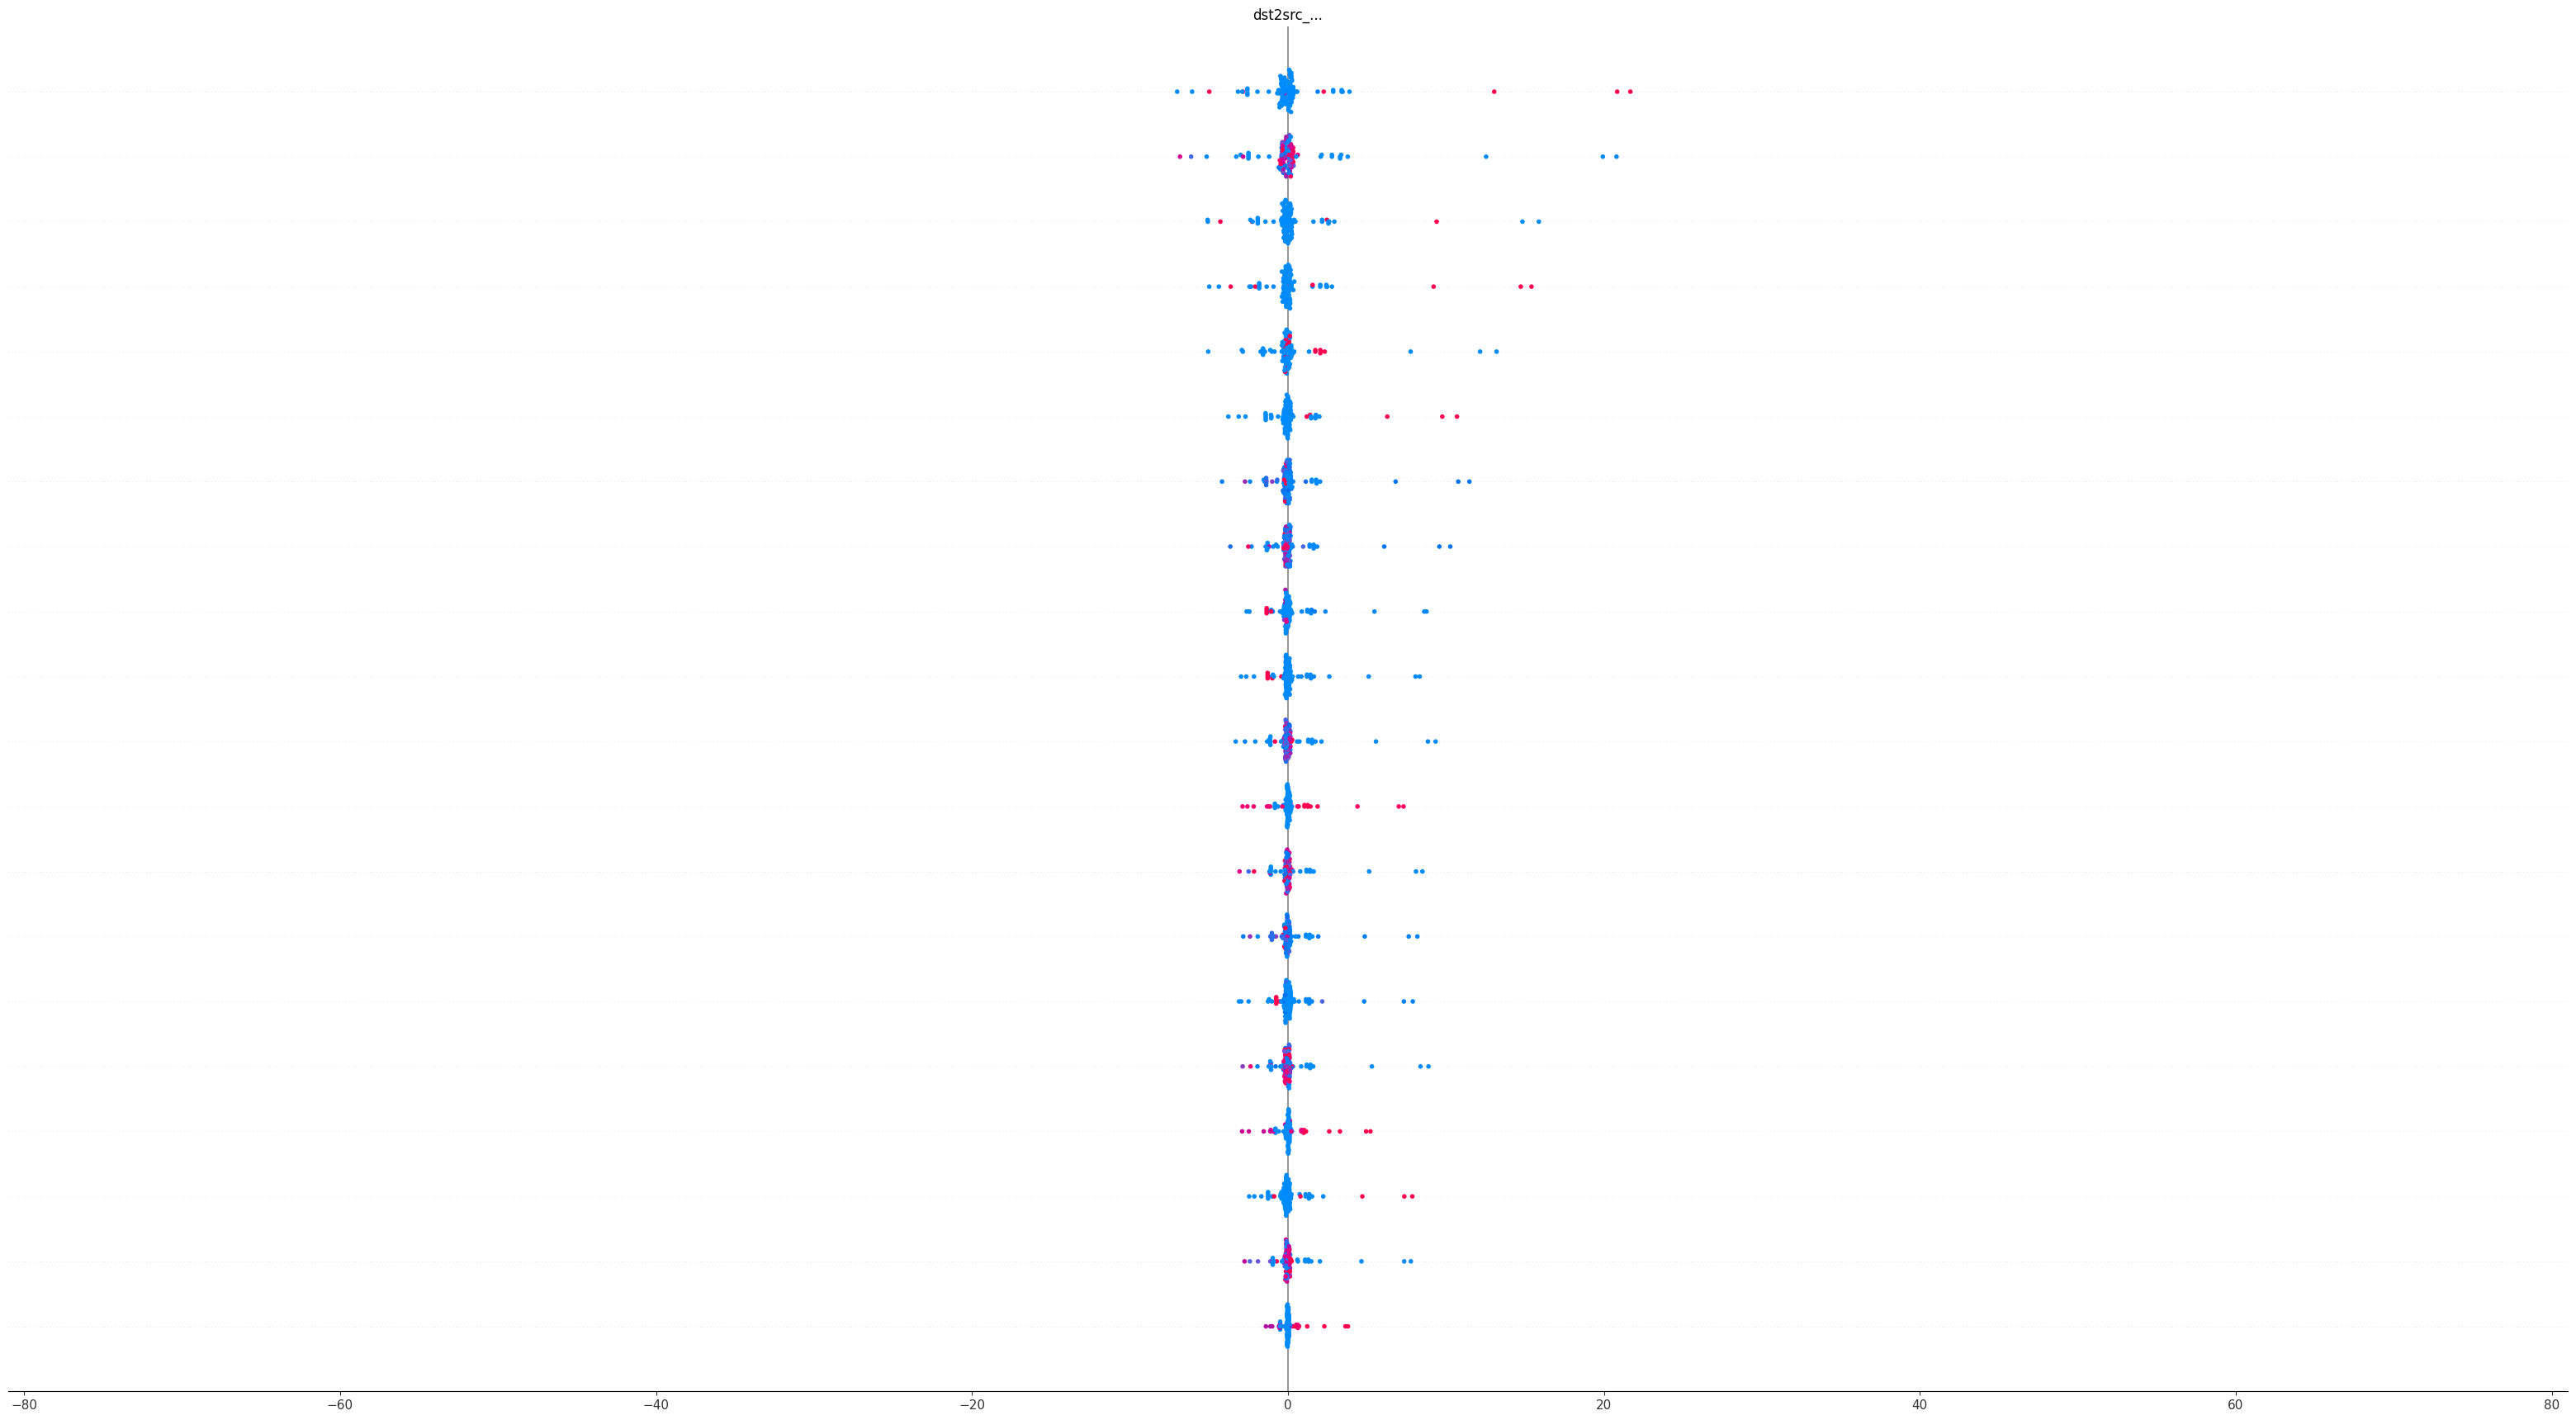

Beeswarm plot saved.

Generating Bar Plot...


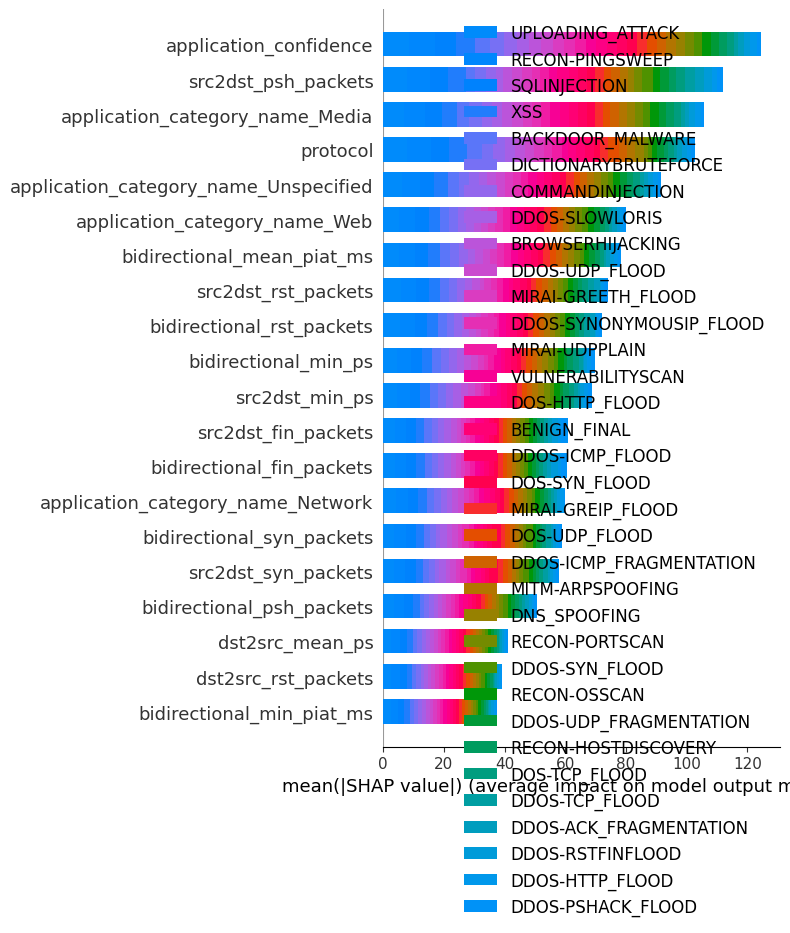

Bar plot saved.

Generating plot for class: DDOS-UDP_FLOOD...

An error occurred while generating class-specific plot: The shape of the shap_values matrix does not match the shape of the provided data matrix.


<Figure size 640x480 with 0 Axes>

In [ ]:
!pip install shap
import shap
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Kayıt Dizini ---
PLOTS_SAVE_PATH = '/content/drive/MyDrive/CMP656/plots/'
# Hedef klasörün mevcut olduğundan emin ol, yoksa oluştur
os.makedirs(PLOTS_SAVE_PATH, exist_ok=True)
print(f"Plots will be saved to: {PLOTS_SAVE_PATH}")


print(f"\n--- Starting SHAP Analysis ---")

# SHAP için arka plan ve test verisi örneklemleri
background_data = X_train_tensor[np.random.choice(X_train_tensor.shape[0], 200, replace=False)].to(device)
test_data_for_shap = X_test_tensor[np.random.choice(X_test_tensor.shape[0], 100, replace=False)].to(device)

# SHAP Explainer ve Değerlerin Hesaplanması
explainer = shap.DeepExplainer(model, background_data)
shap_values = explainer.shap_values(test_data_for_shap)
print("--- SHAP values calculated. Generating and saving plots... ---")

# Kolon isimleri listesi (önceki adımdan geldiği varsayılıyor)
# feature_names = ...

# --- GÖRSEL 1: ÖZET GRAFİĞİ (BEESWARM) ---
print("\nGenerating Beeswarm Plot...")
plt.title('Genel Özellik Önemi (SHAP Beeswarm Plot)')
shap.summary_plot(shap_values, test_data_for_shap.cpu(), feature_names=feature_names,
                  class_names=le.classes_, plot_type="dot", max_display=20, show=False)

# --- DEĞİŞİKLİK: Grafiği kaydet ve göster ---
plt.savefig(os.path.join(PLOTS_SAVE_PATH, 'shap_summary_beeswarm.png'), bbox_inches='tight')
plt.show()
plt.close() # Belleği temizle
print("Beeswarm plot saved.")


# --- GÖRSEL 2: BAR GRAFİĞİ - ORTALAMA ETKİ ---
print("\nGenerating Bar Plot...")
plt.title('Genel Özellik Önemi (SHAP Bar Plot)')
shap.summary_plot(shap_values, feature_names=feature_names,
                  class_names=le.classes_, plot_type="bar", max_display=20, show=False)

# --- DEĞİŞİKLİK: Grafiği kaydet ve göster ---
plt.savefig(os.path.join(PLOTS_SAVE_PATH, 'shap_summary_bar.png'), bbox_inches='tight')
plt.show()
plt.close() # Belleği temizle
print("Bar plot saved.")


# --- GÖRSEL 3: TEK BİR SINIF İÇİN ÖZELLİK ÖNEMİ ---
try:
    target_class_name = 'DDOS-UDP_FLOOD'
    target_class_index = list(le.classes_).index(target_class_name)

    print(f"\nGenerating plot for class: {target_class_name}...")
    plt.title(f'Özellik Önemi: {target_class_name}')
    shap.summary_plot(shap_values[target_class_index], test_data_for_shap.cpu(),
                      feature_names=feature_names, plot_type="dot", max_display=20, show=False)

    # --- DEĞİŞİKLİK: Grafiği kaydet ve göster ---
    plt.savefig(os.path.join(PLOTS_SAVE_PATH, f'shap_summary_{target_class_name}.png'), bbox_inches='tight')
    plt.show()
    plt.close() # Belleği temizle
    print(f"Plot for class '{target_class_name}' saved.")

except ValueError:
    print(f"\nClass '{target_class_name}' not found in the sampled data's predictions.")
except Exception as e:
    print(f"\nAn error occurred while generating class-specific plot: {e}")

Background set size: 340
SHAP test set size:  1020


NameError: name 'PLOTS_SAVE_PATH' is not defined

<Figure size 1200x800 with 0 Axes>

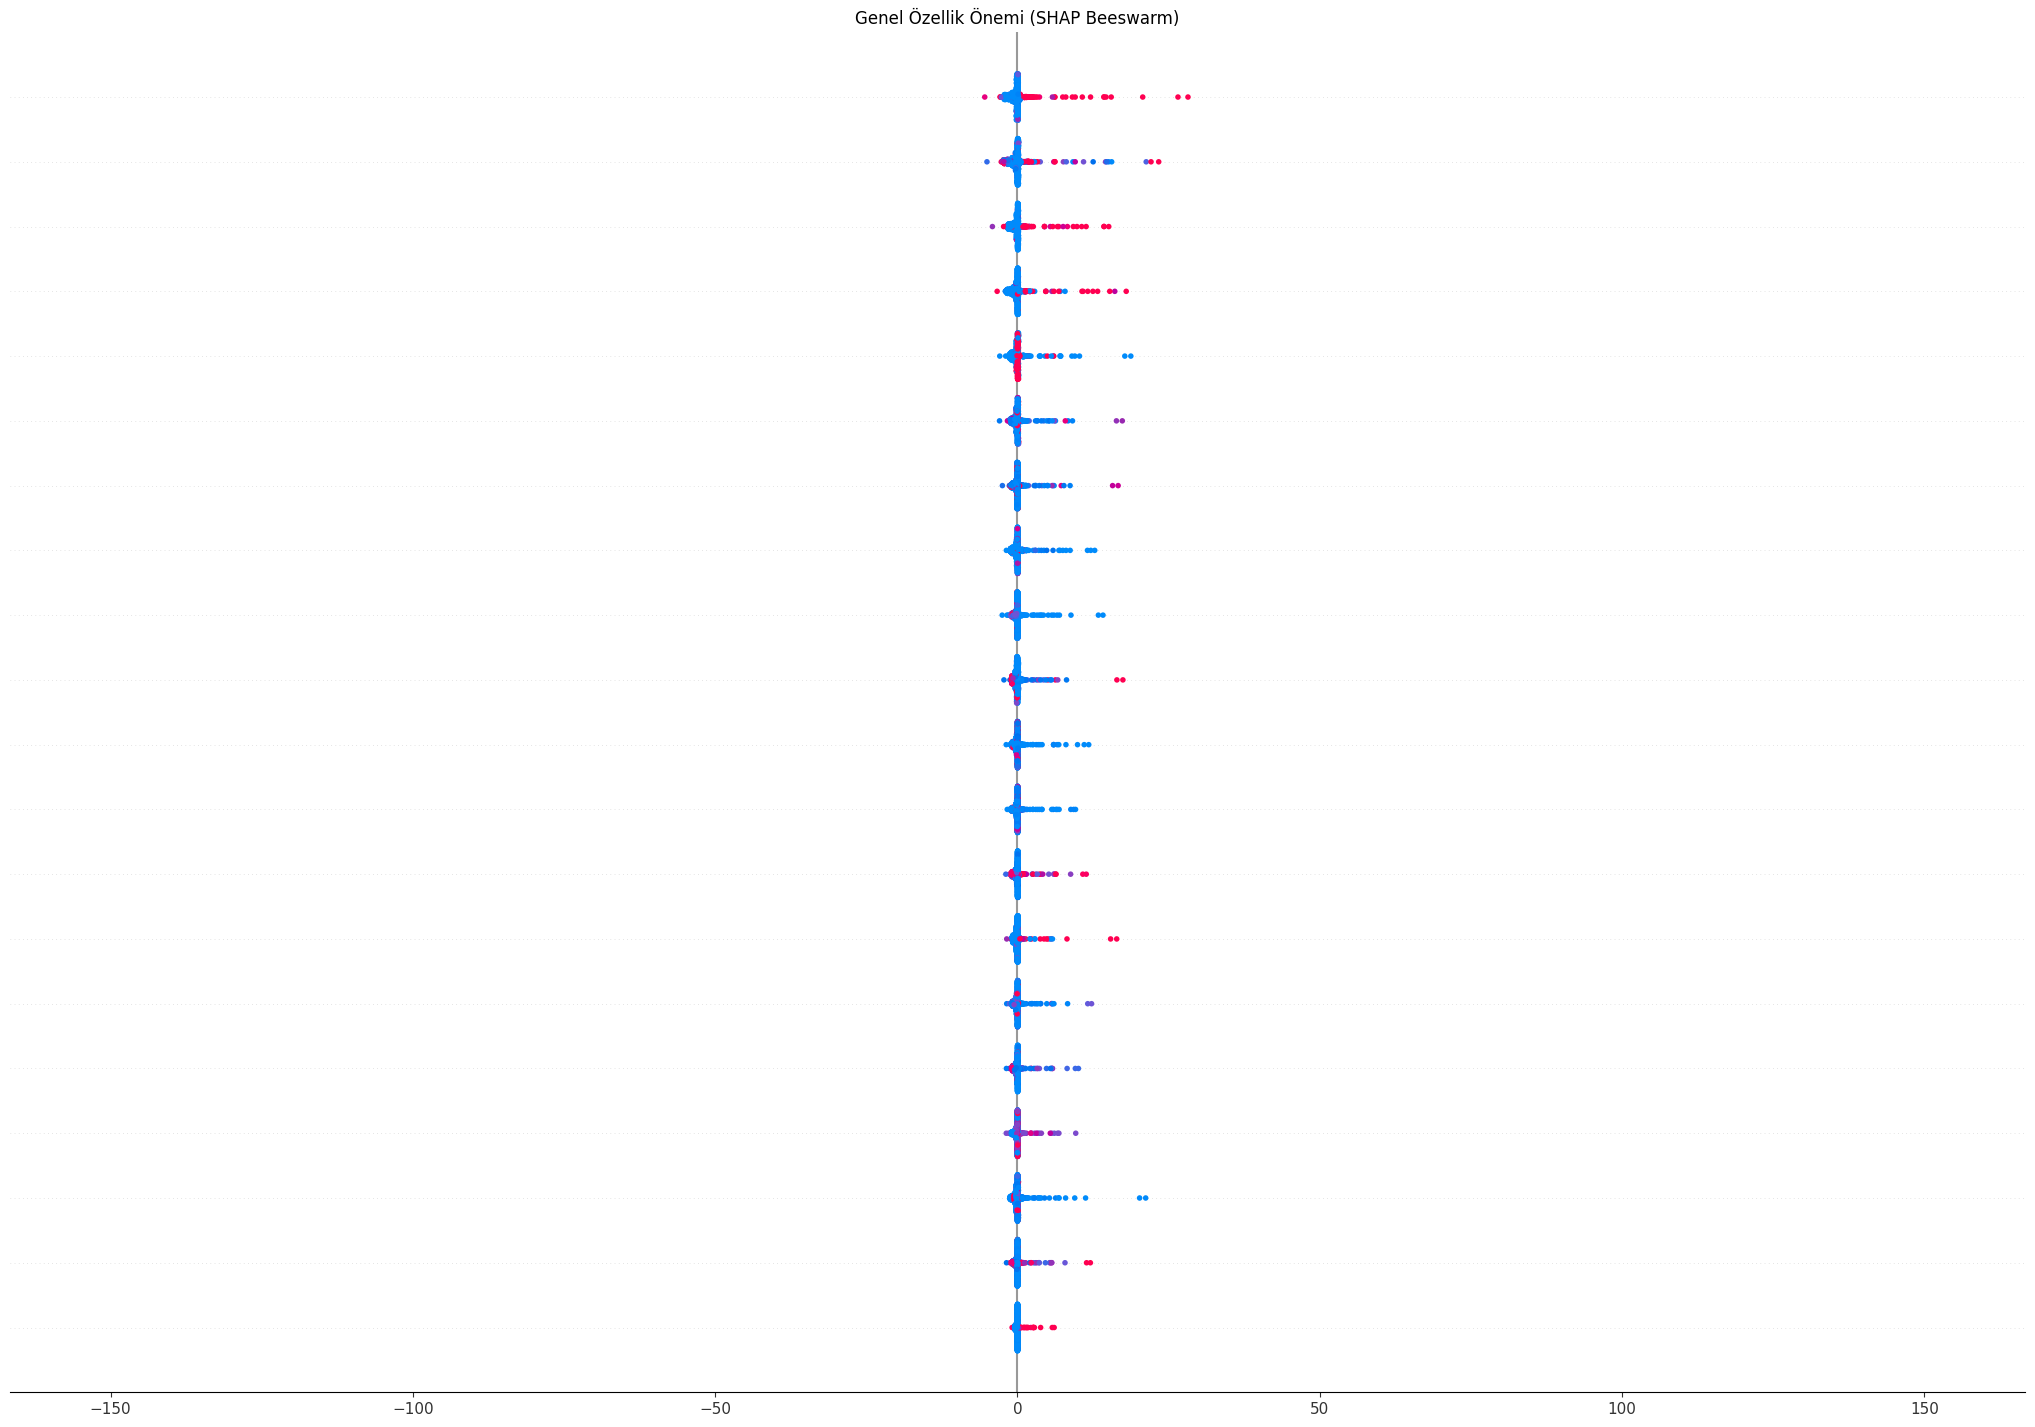

In [ ]:
!pip install shap
import shap
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1) NumPy’a dönüştür ve etiketleri al ---
X_train_np = X_train_tensor.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()
X_test_np  = X_test_tensor.cpu().numpy()
y_test_np  = y_test_tensor.cpu().numpy()

# --- 2) Stratified örnekleme fonksiyonu ---
def stratified_sample(y, per_class):
    """
    y: 1-D numpy array of labels
    per_class: her sınıftan çekilecek maksimum örnek sayısı
    returns: seçilen indislerin listesi
    """
    idxs = []
    for cls in np.unique(y):
        cls_idxs = np.where(y == cls)[0]
        k = min(len(cls_idxs), per_class)
        sampled = np.random.choice(cls_idxs, k, replace=False)
        idxs.extend(sampled)
    np.random.shuffle(idxs)
    return idxs

# --- 3) Background (DeepExplainer) için çekim ---
# Her sınıftan 10 örnek: toplam ~33×10 = 330 örnek
bg_idxs = stratified_sample(y_train_np, per_class=10)
background_data = torch.tensor(
    X_train_np[bg_idxs],
    dtype=X_train_tensor.dtype,
    device=device
)

# --- 4) SHAP testi için çekim ---
# Her sınıftan 30 örnek: toplam ~33×30 = 990 örnek
test_idxs = stratified_sample(y_test_np, per_class=30)
test_data_for_shap = torch.tensor(
    X_test_np[test_idxs],
    dtype=X_test_tensor.dtype,
    device=device
)

print(f"Background set size: {background_data.shape[0]}")
print(f"SHAP test set size:  {test_data_for_shap.shape[0]}")

explainer = shap.DeepExplainer(model, background_data)
shap_values = explainer.shap_values(test_data_for_shap)

# --- 3) Test setini DataFrame’e çevir (feature isimleri için) ---
features_df = pd.DataFrame(
    test_data_for_shap.cpu().numpy(),
    columns=feature_names
)

# --- 4) Beeswarm Plot (multi-class) ---
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    features_df,
    plot_type="dot",
    max_display=20,
    class_names=le.classes_,
    show=False
)
plt.title('Genel Özellik Önemi (SHAP Beeswarm)')
plt.subplots_adjust(left=0.30, right=0.95, top=0.88, bottom=0.08)
plt.savefig(os.path.join(PLOTS_SAVE_PATH, 'shap_beeswarm.png'), dpi=150)
plt.close()

# --- 5) Genel Ortalama |SHAP| Bar Plot ---
# Tüm sınıf ve örnekler üzerinden mutlak değer ortalamasını al
all_abs = np.abs(np.vstack(shap_values))   # (n_classes * n_samples, n_features)
mean_abs = np.mean(all_abs, axis=0)        # (n_features,)

# En önemli 20 feature’ı seç
top_n = 20
top_idx = np.argsort(mean_abs)[-top_n:][::-1]
top_feats = [feature_names[i] for i in top_idx]
top_vals  = mean_abs[top_idx]

plt.figure(figsize=(10, 8))
plt.barh(top_feats, top_vals)
plt.gca().invert_yaxis()
plt.xlabel('Mean |SHAP value|')
plt.title('Genel Özellik Önemi (Mean |SHAP|)')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_SAVE_PATH, 'shap_mean_bar.png'), dpi=150)
plt.close()

# --- 6) Sınıf Bazlı Bar Plot (her sınıf için ayrı) ---
for i, cls in enumerate(le.classes_):
    class_mean = np.abs(shap_values[i]).mean(axis=0)
    top_idx_c  = np.argsort(class_mean)[-top_n:][::-1]
    top_feats_c = [feature_names[j] for j in top_idx_c]
    top_vals_c  = class_mean[top_idx_c]

    plt.figure(figsize=(10, 6))
    plt.barh(top_feats_c, top_vals_c)
    plt.gca().invert_yaxis()
    plt.xlabel('Mean |SHAP value|')
    plt.title(f'Özellik Önemi: {cls}')
    plt.tight_layout()
    fname = f"shap_bar_{cls.replace('/', '_')}.png"
    plt.savefig(os.path.join(PLOTS_SAVE_PATH, fname), dpi=150)
    plt.close()


In [ ]:
X_train_np.shape

(27630199, 87)

#Generate Bot IoT Samples and Test The Model

In [ ]:
!pip install nfstream

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 25.5 MB/s eta 0:00:00



### Generate .csv flow files of Bot IoT
```
import os
from nfstream import NFStreamer
from tqdm import tqdm
import pandas as pd

# PCAP kök dizini
PCAP_DIRECTORY = '/content/drive/MyDrive/CMP656/dataset/BotIoT'

# Tüm alt dizinlerdeki pcap dosyalarını gez
for root, dirs, files in os.walk(PCAP_DIRECTORY):
    for fname in files:
        if not fname.endswith('.pcap'):
            continue

        pcap_path = os.path.join(root, fname)
        # Çıktı CSV dosya yolu: aynı klasörde, .pcap -> .csv
        csv_path = os.path.splitext(pcap_path)[0] + '.csv'

        # Eğer çıktı zaten varsa atla
        if os.path.exists(csv_path):
            print(f"Skipping {fname}, already exists.")
            continue

        print(f"Processing {fname} ...")
        # NFStream ile flow’ları çıkar
        streamer = NFStreamer(
          source=pcap_path,
          decode_tunnels=True,          # Tünellenmiş (VXLAN, GRE vb.) trafiği analiz et
          statistical_analysis=True    # İstatistiksel analizleri (IAT, packet sizes) etkinleştir
)

        df_flow = streamer.to_pandas()

        # Label: bulunduğu klasörün adı, büyük harf
        label = os.path.basename(root).upper()
        df_flow['label'] = label

        # CSV olarak kaydet
        df_flow.to_csv(csv_path, index=False)
        # Belleği boşalt
        del df_flow
```



In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

import pandas as pd
import numpy as np
import glob
import os
import gc # Garbage Collector modülünü içe aktar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm



# CSV dosyalarının bulunduğu kök dizin
CSV_DIRECTORY = '/content/drive/MyDrive/CMP656/dataset/BotIoT'
print(f"Searching for CSV files in subdirectories of: {CSV_DIRECTORY}")

csv_files = glob.glob(os.path.join(CSV_DIRECTORY, '*', '*.csv'))

if not csv_files:
    print("No CSV files found...")
else:
    print(f"Found {len(csv_files)} CSV files in subdirectories.")

    df_list = []
    for f in tqdm(csv_files, desc="Loading CSV files"):
        try:
            df_list.append(pd.read_csv(f))
        except Exception as e:
            print(f"Could not read {f}: {e}")

    df = pd.concat(df_list, ignore_index=True)
    print("All CSV files have been concatenated into a single DataFrame.")

    # --- BELLEK TEMİZLİĞİ 1 ---
    # df_list artık gerekli değil, belleği boşaltalım.
    del df_list
    gc.collect()
    print("Cleaned up df_list from memory.")
    # --------------------------

    # --- YENİ: Veri tiplerini optimize et ---
    df = reduce_mem_usage(df)
    # -------------------------------------

    print("-" * 50)
    print("Initial DataFrame Info:")
    df.info(verbose=False)
    print("\nLabel Distribution:")
    print(df['label'].value_counts())
    print("-" * 50)

    # Adım 2: Veri Temizliği ve Özellik Mühendisliği
    columns_to_drop = [
        'id', 'expiration_id', 'src_ip', 'src_mac', 'src_port', 'dst_ip', 'dst_mac', 'dst_port',
        'src_oui', 'dst_oui', 'ip_version', 'vlan_id', 'tunnel_id', 'bidirectional_first_seen_ms',
        'bidirectional_last_seen_ms', 'src2dst_first_seen_ms', 'src2dst_last_seen_ms',
        'dst2src_first_seen_ms', 'dst2src_last_seen_ms', 'application_name',
        'application_is_guessed', 'requested_server_name', 'client_fingerprint',
        'server_fingerprint', 'user_agent', 'content_type'
    ]
    existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    df.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"Dropped {len(existing_cols_to_drop)} unnecessary columns.")

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if 'label' in categorical_cols:
        categorical_cols.remove('label')

    if categorical_cols:
        print(f"\nApplying One-Hot Encoding to: {categorical_cols}")
        df = pd.get_dummies(df, columns=categorical_cols, dummy_na=True, prefix=categorical_cols)

    df['label'] = le.transform(df['label'])

    # ... Diğer adımlar ...
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    for c in original_columns:
      if c not in df.columns:
          df[c] = 0

    X = df.drop(columns=['label'])
    xcols = X.columns.tolist()
    X = X.reindex(columns=feature_names, fill_value=0)
    y = df['label']

    del df
    gc.collect()


    X_test_scaled = scaler.transform(X)  # fit_transform: test set için ayrı scaler!


    print("Test set hazırlanmıştır:")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")
    print(f"y_test shape: {y_test.shape}")




Searching for CSV files in subdirectories of: /content/drive/MyDrive/CMP656/dataset/BotIoT
Found 27 CSV files in subdirectories.


Loading CSV files:  19%|█▊        | 5/27 [00:10<00:44,  2.04s/it]<ipython-input-24-57126056>:35: DtypeWarning: Columns (81) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:  44%|████▍     | 12/27 [00:23<00:28,  1.93s/it]<ipython-input-24-57126056>:35: DtypeWarning: Columns (81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:  56%|█████▌    | 15/27 [00:29<00:24,  2.01s/it]<ipython-input-24-57126056>:35: DtypeWarning: Columns (81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:  89%|████████▉ | 24/27 [00:32<00:00,  3.34it/s]<ipython-input-24-57126056>:35: DtypeWarning: Columns (83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:  96%|█████████▋| 26/27 [00:32<00:00,

All CSV files have been concatenated into a single DataFrame.
Cleaned up df_list from memory.
Memory usage decreased to 1360.63 Mb (52.7% reduction)
--------------------------------------------------
Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336561 entries, 0 to 4336560
Columns: 87 entries, id to label
dtypes: float32(12), int16(12), int32(18), int64(6), int8(25), object(14)
memory usage: 1.3+ GB

Label Distribution:
label
DOS-TCP_FLOOD      1048682
DDOS-UDP_FLOOD     1048626
DOS-UDP_FLOOD      1048626
DDOS-TCP_FLOOD     1048608
RECON-OSSCAN         88850
DOS-HTTP_FLOOD       31387
DDOS-HTTP_FLOOD      21782
Name: count, dtype: int64
--------------------------------------------------
Dropped 26 unnecessary columns.

Applying One-Hot Encoding to: ['application_category_name']


NameError: name 'X_test' is not defined

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


# Cihazı seç
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---")

# Test verisini tensöre çevir
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y.values, dtype=torch.long)

# DataLoader
BATCH_SIZE = 256
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# MODELIN YÜKLENMESİ ÖRNEK (zaten yüklüyse bu satıra gerek yok)
# model = torch.load("my_trained_model.pt", map_location=device)

# Modeli eval moduna al
model.eval()
model.to(device)

# Tahmin ve gerçek etiketleri saklamak için
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

# Sonuçları birleştir
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

# Accuracy’i hesapla
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}\n")

# Sınıf isimlerini LabelEncoder’dan almak istersen:
# label_names = le.classes_

# Diğer metrikler
print("Test Set Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


--- Using device: cuda ---
Accuracy: 0.0768

Test Set Classification Report:



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           5     0.0022    0.1101    0.0044     21782
          10     0.0000    0.0000    0.0000         0
          11     0.0000    0.0000    0.0000         0
          12     0.0000    0.0000    0.0000         0
          13     0.0000    0.0000    0.0000   1048608
          14     0.4978    0.0001    0.0002   1048626
          15     0.0000    0.0000    0.0000         0
          18     0.0274    0.7516    0.0529     31387
          19     0.0000    0.0000    0.0000         0
          20     0.0000    0.0000    0.0000   1048682
          21     0.9999    0.2928    0.4530   1048626
          26     0.0000    0.0000    0.0000         0
          27     0.0000    0.0000    0.0000     88850
          29     0.0000    0.0000    0.0000         0
          32     0.0000    0.0000    0.0000         0

    accuracy                         0.0768   4336561
   macro avg     0.0955   

In [ ]:
all_preds

[array([13, 13, 18, 13, 13, 13,  5, 13, 18, 12,  1,  5,  5, 13, 12, 13, 11,
        18, 13, 13, 12, 13, 13, 18, 13,  5, 13, 18, 13,  5, 11, 13, 19, 13,
        13, 12, 18, 19, 13, 12, 13, 13, 13, 13, 18,  5, 18, 12, 13, 11, 13,
        13, 13, 13, 12, 18, 13, 12, 18, 12, 11, 13, 13, 12,  5, 12, 13, 13,
        13, 19, 12, 18, 13, 13, 13, 18, 13, 13, 13, 13,  5, 18, 13, 18, 11,
        12, 11, 13, 13,  5, 13, 12, 13, 12, 11, 12, 13, 13,  5,  5, 11, 18,
        18, 13, 19, 12, 11, 12, 13, 13, 18, 11,  5, 13, 13, 13, 13, 18, 12,
        11, 12, 12, 13, 13, 12,  5, 13, 13,  5, 11, 13, 11, 13, 13, 13, 18,
        13, 13, 12,  5, 11, 11, 13, 13, 13, 18, 18, 13, 12, 13, 13, 18, 19,
        13, 13, 13, 18, 13, 13, 13, 13,  5,  5,  5, 11, 18, 13, 13, 13, 13,
        19, 13, 13,  5, 13, 13,  5, 11, 11, 11, 13, 13, 13, 12, 13, 12, 13,
        18, 13, 13,  5, 13, 12, 13, 13, 13, 13, 18, 12, 12,  5, 11,  9, 18,
        12, 19, 19, 18,  1,  5, 18, 12, 13, 11, 13, 13, 13, 18, 11, 19, 13,
        12, 

# Presentation ARP-PROBE

In [ ]:
import os
from scapy.all import rdpcap
import pandas as pd
import matplotlib.pyplot as plt

pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/MITM-ArpSpoofing/MITM-ArpSpoofing.pcap'
df = process(pcap_path, 1)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/MITM-ArpSpoofing/MITM-ArpSpoofing1.pcap'
df_to_add = process(pcap_path, 1)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/Benign_Final/BenignTraffic.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/Benign_Final/BenignTraffic1.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/Benign_Final/BenignTraffic2.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)
pcap_path = '/content/drive/MyDrive/CMP656/dataset/CIC/Benign_Final/BenignTraffic3.pcap'
df_to_add = process(pcap_path, 0)
df = pd.concat([df, df_to_add], axis=0, ignore_index=True)


Reading PCAP file.
Number of total packages: 2491622
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 600143
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 3664164
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 2988642
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 3138002
Pre-processing is starting.
Tamamen NaN olan sütunlar: []
Reading PCAP file.
Number of total packages: 1311897
Pre-processing is starting.
Tamamen NaN olan sütunlar: []


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#del X_test, y_test

#X_test2, y_test2 = df_to_numpy(df)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_t2  = torch.from_numpy(X_test2).to(device)
y_test_t2  = torch.from_numpy(y_test2).to(device)

batch_size = 64

test_ds  = TensorDataset(X_test_t2, y_test_t2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1) MLP modelini tanımla
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 2) Model, loss, optimizer ayarları
input_dim   = X_test_t2.shape[1]              # özellik sayısı
hidden_dims = [42, 16,8,8]                     # istediğin mimari
output_dim  = len(torch.unique(y_test_t))  # sınıf sayısı

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, hidden_dims, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/CMP656/model/mlp_classifier1.pth", map_location=device))

<All keys matched successfully>

In [ ]:
# 4) Test (Değerlendirme)
model.eval()
correct = 0
total   = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds  = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)

accuracy = correct / total
print(f"Test Doğruluk: {accuracy:.4f}")

Test Doğruluk: 0.8851


In [ ]:
import torch

# Ensure model is in evaluation mode
model.eval()

# Disable gradient calculations for inference
with torch.no_grad():
    # Number of examples in the test dataset
    num_test = len(test_dataset)
    # Sample 3 random indices from [0, num_test)
    random_idxs = torch.randperm(num_test)[:3]

    correct = 0
    for idx in random_idxs:
        # Fetch a single (feature, label) pair from the test set
        x, y_true = test_dataset[idx]
        # Move to device and add batch dimension
        x = x.to(device).unsqueeze(0)
        y_true = y_true.to(device)

        # Forward pass
        logits = model(x)
        # Predicted class is the argmax of the logits
        y_pred = torch.argmax(logits, dim=1)

        # Check correctness
        is_correct = (y_pred == y_true).item()
        correct += is_correct

        print(f"Test sample idx={idx.item()}: true={y_true.item()}, pred={y_pred.item()}, correct={is_correct}")

    # Compute accuracy over the 3 random test samples
    accuracy = correct / 3 * 100
    print(f"\nAccuracy on these 3 random test samples: {accuracy:.2f}%")


# Presentation Multi-Class

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import gc # Garbage Collector modülünü içe aktar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

# --- YENİ: Bellek Kullanımını Azaltma Fonksiyonu ---
def reduce_mem_usage(df, verbose=True):
    """DataFrame'deki kolonların veri tiplerini optimize ederek bellek kullanımını azaltır."""
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df
# ----------------------------------------------------


# CSV dosyalarının bulunduğu kök dizin
CSV_DIRECTORY = '/content/drive/MyDrive/CMP656/dataset/CIC'
print(f"Searching for CSV files in subdirectories of: {CSV_DIRECTORY}")

csv_files = glob.glob(os.path.join(CSV_DIRECTORY, '*', '*.csv'))

if not csv_files:
    print("No CSV files found...")
else:
    print(f"Found {len(csv_files)} CSV files in subdirectories.")

    df_list = []
    for f in tqdm(csv_files, desc="Loading CSV files"):
        try:
            df_list.append(pd.read_csv(f))
        except Exception as e:
            print(f"Could not read {f}: {e}")

    df = pd.concat(df_list, ignore_index=True)
    print("All CSV files have been concatenated into a single DataFrame.")

    # --- BELLEK TEMİZLİĞİ 1 ---
    # df_list artık gerekli değil, belleği boşaltalım.
    del df_list
    gc.collect()
    print("Cleaned up df_list from memory.")
    # --------------------------

    # --- YENİ: Veri tiplerini optimize et ---
    df = reduce_mem_usage(df)
    # -------------------------------------

    print("-" * 50)
    print("Initial DataFrame Info:")
    df.info(verbose=False)
    print("\nLabel Distribution:")
    print(df['label'].value_counts())
    print("-" * 50)

    # Adım 2: Veri Temizliği ve Özellik Mühendisliği
    columns_to_drop = [
        'id', 'expiration_id', 'src_ip', 'src_mac', 'src_port', 'dst_ip', 'dst_mac', 'dst_port',
        'src_oui', 'dst_oui', 'ip_version', 'vlan_id', 'tunnel_id', 'bidirectional_first_seen_ms',
        'bidirectional_last_seen_ms', 'src2dst_first_seen_ms', 'src2dst_last_seen_ms',
        'dst2src_first_seen_ms', 'dst2src_last_seen_ms', 'application_name',
        'application_is_guessed', 'requested_server_name', 'client_fingerprint',
        'server_fingerprint', 'user_agent', 'content_type'
    ]
    existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    df.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"Dropped {len(existing_cols_to_drop)} unnecessary columns.")

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if 'label' in categorical_cols:
        categorical_cols.remove('label')


    if categorical_cols:
        print(f"\nApplying One-Hot Encoding to: {categorical_cols}")
        df = pd.get_dummies(df, columns=categorical_cols, dummy_na=True, prefix=categorical_cols)

    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

    # ... Diğer adımlar ...
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    X = df.drop(columns=['label'])
    y = df['label']

    # --- ÇÖZÜM: Kolon isimlerini X'i silmeden önce bir listeye kaydet ---
    feature_names = X.columns.tolist()
    print("Feature names have been saved to a list.")

    # --- BELLEK TEMİZLİĞİ 2 ---
    # df artık gerekli değil, X ve y oluşturuldu.
    original_columns = list(df.columns)
    del df
    gc.collect()
    print("Cleaned up main DataFrame from memory.")
    # --------------------------

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- BELLEK TEMİZLİĞİ 3 ---
    # X ve y artık gerekli değil, train/test setleri oluşturuldu.
    del X, y
    gc.collect()
    print("Cleaned up X and y from memory.")
    # --------------------------

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- BELLEK TEMİZLİĞİ 4 ---
    # Ölçeklenmemiş train/test setleri artık gerekli değil.
    del X_train, X_test
    gc.collect()
    print("Cleaned up unscaled train/test sets from memory.")
    # --------------------------

    print("-" * 50)
    print("Pre-processing complete! You can now use the following variables for model training:")
    print(f"X_train_scaled: (shape {X_train_scaled.shape})")
    print(f"y_train: (shape {y_train.shape})")
    print(f"X_test_scaled: (shape {X_test_scaled.shape})")
    print(f"y_test: (shape {y_test.shape})")

Searching for CSV files in subdirectories of: /content/drive/MyDrive/CMP656/dataset/CIC
Found 87 CSV files in subdirectories.


Loading CSV files:   6%|▌         | 5/87 [00:07<01:45,  1.29s/it]<ipython-input-57-2668725265>:54: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:   8%|▊         | 7/87 [00:07<00:55,  1.45it/s]<ipython-input-57-2668725265>:54: DtypeWarning: Columns (82,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:   9%|▉         | 8/87 [00:07<00:47,  1.65it/s]<ipython-input-57-2668725265>:54: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(f))
Loading CSV files:  10%|█         | 9/87 [00:10<01:34,  1.21s/it]


KeyboardInterrupt: 

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# --- 1. Cihaz Kurulumu ve Veri Hazırlığı ---

# Cihazı belirle (GPU varsa kullan, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---")

# NumPy dizilerini PyTorch Tensor'larına dönüştür
# Özellikler float, etiketler ise CrossEntropyLoss için long olmalı
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long) # y_train bir Pandas Serisi olduğu için .values kullandık
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# DataLoader'ları oluştur (Veriyi toplu halde ve karıştırarak modele sunmak için)
BATCH_SIZE = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Test/Validation verisi için de DataLoader oluştur
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. Deep Learning Model Tanımı ---

class DeepNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, p_dropout=0.4):
        """
        input_dim   : Giriş özellik sayısı
        hidden_dims : Gizli katman boyutları listesi, örn. [128, 64, 32]
        num_classes : Sınıf sayısı
        p_dropout   : Dropout oranı
        """
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, h),
                nn.BatchNorm1d(h),      # Katmanlar arası normalizasyon
                nn.ReLU(),  # Aktivasyon fonksiyonu
                nn.Dropout(p_dropout)   # Overfitting'i önlemek için
            ])
            prev_dim = h

        # Son katman (logit'leri üretir, softmax burada uygulanmaz)
        layers.append(nn.Linear(prev_dim, num_classes))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --- 3. Model Başlatma ve Optimizasyon Araçları ---

# Model parametrelerini hazırla
input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train)) # Etiket sayısını y_train'den al
hidden_dims = [128, 64, 32]

# Modeli oluştur ve cihaza taşı
model = DeepNet(input_dim, hidden_dims, num_classes).to(device)

# Kayıp fonksiyonu ve optimize ediciyi tanımla
# nn.CrossEntropyLoss, içinde softmax aktivasyonunu barındırır.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

print("\n--- Model ve optimizasyon araçları hazır ---")
print(model)

# --- 4. Eğitim ve Değerlendirme Döngüsü ---



In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/CMP656/model/iot_intrusion_detector_v2.pth", map_location=device))

<All keys matched successfully>

In [ ]:
import torch

# Ensure model is in evaluation mode
model.eval()

# Disable gradient calculations for inference
with torch.no_grad():
    # Number of examples in the test dataset
    num_test = len(test_dataset)
    # Sample 3 random indices from [0, num_test)
    random_idxs = torch.randperm(num_test)[:3]

    correct = 0
    for idx in random_idxs:
        # Fetch a single (feature, label) pair from the test set
        x, y_true = test_dataset[idx]
        # Move to device and add batch dimension
        x = x.to(device).unsqueeze(0)
        y_true = y_true.to(device)

        # Forward pass
        logits = model(x)
        # Predicted class is the argmax of the logits
        y_pred = torch.argmax(logits, dim=1)

        # Check correctness
        is_correct = (y_pred == y_true).item()
        correct += is_correct

        print(f"Test sample idx={idx.item()}: true={y_true.item()}, pred={y_pred.item()}, correct={is_correct}")

    # Compute accuracy over the 3 random test samples
    accuracy = correct / 3 * 100
    print(f"\nAccuracy on these 3 random test samples: {accuracy:.2f}%")


Test sample idx=302524: true=8, pred=8, correct=True
Test sample idx=2284106: true=12, pred=12, correct=True
Test sample idx=1480761: true=13, pred=13, correct=True

Accuracy on these 3 random test samples: 100.00%
